<a href="https://colab.research.google.com/github/sunfflur/frequency-learning/blob/master/EyeQ/Exp_EyeQ_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet50V2

#### Libraries Import

In [ ]:
s = 23
import os
os.environ['PYTHONHASHSEED']=str(s)
import random
random.seed(s)
from numpy.random import seed
seed(s)
from tensorflow.random import set_seed
set_seed(s)

import PIL
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Conv1D, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
#from tensorflow.keras.applications.vgg16 import VGG16
#from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn

!pip install tensorflow-addons 
!pip install tensorflow-recommenders

import tensorflow_addons as tfa
import tensorflow_recommenders as tfrs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Nov  3 00:23:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


#### Drive mount

In [ ]:
### TESSSSSST ###

!sudo add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!sudo apt-get update -qq 2>&1 > /dev/null
!sudo apt -y install -qq google-drive-ocamlfuse 2>&1 > /dev/null
!google-drive-ocamlfuse



debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: www-browser: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: links2: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: elinks: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: links: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: lynx: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: w3m: not found
xdg-open: no method available for opening 'https://accounts.google.com/o/oauth2/auth?client_id=564921029129.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fgd-ocaml-auth.appspot.

In [ ]:
!sudo apt-get install -qq w3m # to act as web browser 
!xdg-settings set default-web-browser w3m.desktop # to set default browser
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package w3m.
(Reading database ... 123947 files and directories currently installed.)
Preparing to unpack .../w3m_0.5.3-36build1_amd64.deb ...
Unpacking w3m (0.5.3-36build1) ...
Setting up w3m (0.5.3-36build1) ...
Processing triggers for mime-support (3.60ubuntu1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
/content
/content/drive
/content
/
Access token retrieved correctly.


#### Data Load

In [ ]:
### data loading ### 
with tf.device('/CPU:0'):
  xm1 = tf.data.experimental.load('/content/drive/MyDrive/Mestrado/Datasets/drd/train data/xm1')
  xm2 = tf.data.experimental.load('/content/drive/MyDrive/Mestrado/Datasets/drd/train data/xm2')
  xmt1 = tf.data.experimental.load('/content/drive/MyDrive/Mestrado/Datasets/drd/test data/xmt1')
  xmt2 = tf.data.experimental.load('/content/drive/MyDrive/Mestrado/Datasets/drd/test data/xmt2')
  
  #concatenate them
  x_train = xm1.concatenate(xm2) #data between 0,1
  x_test = xmt1.concatenate(xmt2) #data between 0,1

#### preprocess

validation split

In [ ]:
def ds_split(ds, ds_size, train_split=0.9, val_split=0.1, shuffle=False, shuffle_size=None):
    assert (train_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=11)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    #test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds

In [ ]:
x_train_x, x_val_x = ds_split(x_train, 10667)

In [ ]:
x_train_x

<TakeDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float64, name=None), TensorSpec(shape=(2,), dtype=tf.float32, name=None))>

In [ ]:
x_train1 = x_train_x.map(lambda x,y: (preprocess_input(x*255),y), num_parallel_calls=tf.data.AUTOTUNE).shuffle(300).batch(32, drop_remainder=True).cache()
x_train1 = x_train1.prefetch(tf.data.AUTOTUNE)

In [ ]:
tf.compat.v1.data.get_output_shapes(x_train1)

(TensorShape([32, 224, 224, 3]), TensorShape([32, 2]))

In [ ]:
x_val1 = x_val_x.map(lambda x,y: (preprocess_input(x*255),y), num_parallel_calls=tf.data.AUTOTUNE).batch(32, drop_remainder=True).cache()
x_val1 = x_val1.prefetch(tf.data.AUTOTUNE)

In [ ]:
tf.compat.v1.data.get_output_shapes(x_val1)

(TensorShape([32, 224, 224, 3]), TensorShape([32, 2]))

In [ ]:
x_test1 = x_test.map(lambda z, y: (preprocess_input(z*255), y), num_parallel_calls=tf.data.AUTOTUNE).batch(32, drop_remainder=True).cache()
x_test1 = x_test1.prefetch(tf.data.AUTOTUNE)

In [ ]:
tf.compat.v1.data.get_output_shapes(x_test1)

(TensorShape([32, 224, 224, 3]), TensorShape([32, 2]))

#### Pre-trained Model

In [ ]:
def pre_trained_model(input_shape, n_classes, optimizer, fine_tune=0):
    """
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training.
    fine_tune: int - The number of pre-trained layers to unfreeze. 
               0 = all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    resnet50_model = ResNet50V2(include_top=True,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    
    if fine_tune > 0:
        for layer in resnet50_model.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in resnet50_model.layers:
            layer.trainable = False
    '''
    for layer in resnet50_model.layers:
      layer.trainable = True
    '''
    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = resnet50_model.layers[-2].output
    #top_model = Flatten(name="flatten")(top_model)
    #top_model = Dense(4096, activation='relu')(top_model)
    #top_model = Dense(128, activation='relu')(top_model)
    #top_model = Dropout(0.25)(top_model)
    output_layer = Dense(n_classes, activation='softmax', name='my_predictions')(top_model)
    
    # Group the convolutional base and new output into a Model object.
    model = Model(inputs=resnet50_model.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
tf.random.set_seed(s) #s
opt = Adam(learning_rate=0.001)
ResNet50_model = pre_trained_model(input_shape=(224,224,3), n_classes=2, optimizer=opt)

In [ ]:
print(ResNet50_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
# ModelCheckpoint callback - save best weights
estopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Mestrado/Experimentos/exp-eyeq/exp-eyeq-pynb/model_resnet50_pt.weights.best.hdf5', save_best_only=True, verbose=0)
history = ResNet50_model.fit(x_train1, epochs=100, verbose=1, validation_data=x_val1, callbacks=[checkpoint, estopping])

Epoch 1/100
300/300 [==============================] - 364s 963ms/step - loss: 0.0911 - accuracy: 0.9677 - val_loss: 0.0483 - val_accuracy: 0.9848
Epoch 2/100
300/300 [==============================] - 38s 128ms/step - loss: 0.0435 - accuracy: 0.9852 - val_loss: 0.0417 - val_accuracy: 0.9858
Epoch 3/100
300/300 [==============================] - 36s 119ms/step - loss: 0.0344 - accuracy: 0.9880 - val_loss: 0.0390 - val_accuracy: 0.9886
Epoch 4/100
300/300 [==============================] - 38s 128ms/step - loss: 0.0292 - accuracy: 0.9905 - val_loss: 0.0372 - val_accuracy: 0.9886
Epoch 5/100
300/300 [==============================] - 35s 118ms/step - loss: 0.0256 - accuracy: 0.9914 - val_loss: 0.0359 - val_accuracy: 0.9886
Epoch 6/100
300/300 [==============================] - 38s 126ms/step - loss: 0.0229 - accuracy: 0.9922 - val_loss: 0.0349 - val_accuracy: 0.9896
Epoch 7/100
300/300 [==============================] - 35s 116ms/step - loss: 0.0208 - accuracy: 0.9930 - val_loss: 0.0342 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


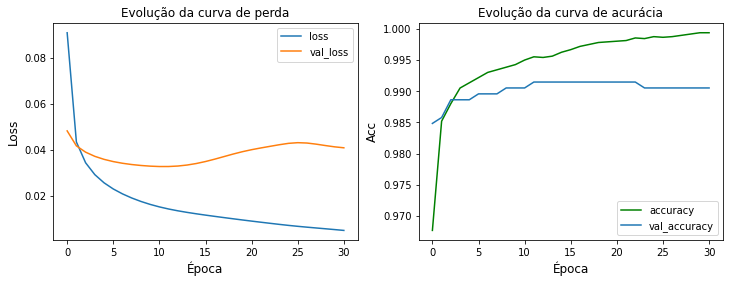

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121), plt.plot(history.history['loss'], label='loss')
plt.subplot(121), plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Época', fontsize=12), plt.ylabel('Loss', fontsize=12)
plt.title('Evolução da curva de perda')
plt.legend()
plt.subplot(122), plt.plot(history.history['accuracy'], label = 'accuracy', color='green')
plt.subplot(122), plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Época', fontsize=12), plt.ylabel('Acc', fontsize=12)
plt.title('Evolução da curva de acurácia')
plt.legend()
plt.show()

In [ ]:
ResNet50_model.load_weights('/content/drive/MyDrive/Mestrado/Experimentos/exp-eyeq/exp-eyeq-pynb/model_resnet50_pt.weights.best.hdf5')

In [ ]:
### TEST ACC ###
scores = ResNet50_model.evaluate(x_test1)
print('\n%s : %.2f%%' % (ResNet50_model.metrics_names[1], scores[1] * 100))

365/365 [==============================] - 251s 471ms/step - loss: 0.0407 - accuracy: 0.9865

accuracy : 98.65%


#### Random initialization

In [ ]:
def non_pre_trained_model(input_shape, n_classes, optimizer, fine_tune=0):
    """
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training.
    fine_tune: int - The number of pre-trained layers to unfreeze. 
               0 = all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    resnet50_model = ResNet50V2(include_top=True,
                     weights=None, 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    '''
    if fine_tune > 0:
        for layer in resnet50_model.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in resnet50_model.layers:
            layer.trainable = False
    '''
    for layer in resnet50_model.layers:
      layer.trainable = True
    
    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = resnet50_model.layers[-2].output
    #top_model = Flatten(name="flatten")(top_model)
    #top_model = Dense(4096, activation='relu')(top_model)
    #top_model = Dense(128, activation='relu')(top_model)
    #top_model = Dropout(0.25)(top_model)
    output_layer = Dense(n_classes, activation='softmax', name='my_predictions')(top_model)
    
    # Group the convolutional base and new output into a Model object.
    model = Model(inputs=resnet50_model.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
tf.random.set_seed(s) #s
opt = Adam(learning_rate=0.001)
ResNet50_model = non_pre_trained_model(input_shape=(224,224,3), n_classes=2, optimizer=opt)

In [ ]:
print(ResNet50_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
# ModelCheckpoint callback - save best weights
estopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Mestrado/Experimentos/exp-eyeq/exp-eyeq-pynb/model_resnet50_rdn.weights.best.hdf5', save_best_only=True, verbose=0)
history = ResNet50_model.fit(x_train1, epochs=100, verbose=1, validation_data=x_val1, callbacks=[checkpoint, estopping])

Epoch 1/100
300/300 [==============================] - 401s 1s/step - loss: 0.2521 - accuracy: 0.9173 - val_loss: 0.3365 - val_accuracy: 0.9110
Epoch 2/100
300/300 [==============================] - 88s 292ms/step - loss: 0.2021 - accuracy: 0.9344 - val_loss: 4.2251 - val_accuracy: 0.3163
Epoch 3/100
300/300 [==============================] - 88s 294ms/step - loss: 0.1577 - accuracy: 0.9471 - val_loss: 0.4691 - val_accuracy: 0.8873
Epoch 4/100
300/300 [==============================] - 100s 334ms/step - loss: 0.1258 - accuracy: 0.9551 - val_loss: 0.2523 - val_accuracy: 0.9195
Epoch 5/100
300/300 [==============================] - 88s 294ms/step - loss: 0.1124 - accuracy: 0.9622 - val_loss: 0.2872 - val_accuracy: 0.9186
Epoch 6/100
300/300 [==============================] - 88s 293ms/step - loss: 0.1017 - accuracy: 0.9639 - val_loss: 0.3271 - val_accuracy: 0.9138
Epoch 7/100
300/300 [==============================] - 101s 337ms/step - loss: 0.0969 - accuracy: 0.9664 - val_loss: 0.2517 -

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


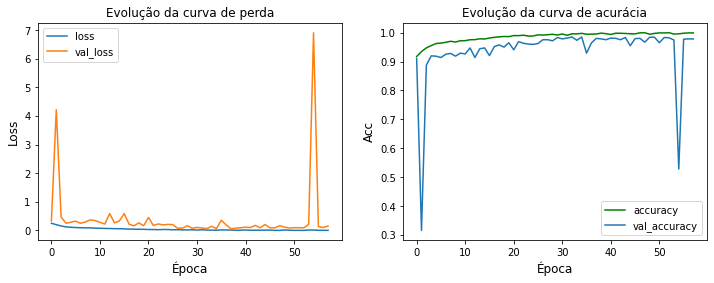

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121), plt.plot(history.history['loss'], label='loss')
plt.subplot(121), plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Época', fontsize=12), plt.ylabel('Loss', fontsize=12)
plt.title('Evolução da curva de perda')
plt.legend()
plt.subplot(122), plt.plot(history.history['accuracy'], label = 'accuracy', color='green')
plt.subplot(122), plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Época', fontsize=12), plt.ylabel('Acc', fontsize=12)
plt.title('Evolução da curva de acurácia')
plt.legend()
plt.show()

In [ ]:
ResNet50_model.load_weights('/content/drive/MyDrive/Mestrado/Experimentos/exp-eyeq/exp-eyeq-pynb/model_resnet50_rdn.weights.best.hdf5')

In [ ]:
### TEST ACC ###
scores = ResNet50_model.evaluate(x_test1)
print('\n%s : %.2f%%' % (ResNet50_model.metrics_names[1], scores[1] * 100))

365/365 [==============================] - 168s 355ms/step - loss: 0.1107 - accuracy: 0.9736

accuracy : 97.36%
